In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="sgUmJcKajnsJigJKvbhR")
project = rf.workspace("machine-learning-4mojt").project("acl-and-pcl-detection")
version = project.version(1)
dataset = version.download("yolov8")
                

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ACL-and-PCL-Detection-1 in yolov8:: 100%|██████████| 1946/1946 [00:00<00:00, 8401.73it/s]


In [2]:
%pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6170.1/8062.4 GB disk)


In [3]:
import os
import random
import shutil
from glob import glob

# Define dataset paths
dataset_path = "/kaggle/working/ACL-and-PCL-Detection-1"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "valid")
test_path = os.path.join(dataset_path, "test")

# Create necessary folders if they don’t exist
for folder in [train_path, valid_path, test_path]:
    os.makedirs(os.path.join(folder, "images"), exist_ok=True)
    os.makedirs(os.path.join(folder, "labels"), exist_ok=True)

# Check if dataset is already split
if len(glob(os.path.join(valid_path, "images", "*.*"))) > 0 or len(glob(os.path.join(test_path, "images", "*.*"))) > 0:
    print("⚠️ Dataset has already been split. Skipping re-splitting!")
else:
    # Get all image paths (supporting multiple formats)
    image_paths = glob(os.path.join(train_path, "images", "*.*"))  # Handles jpg, png, jpeg
    random.shuffle(image_paths)  # Shuffle images for random split

    # Define split sizes
    total_images = len(image_paths)
    test_count = int(0.2 * total_images)
    valid_count = int(0.1 * total_images)

    # Move 20% of images to test set
    for img in image_paths[:test_count]:
        label = img.replace("images", "labels").rsplit(".", 1)[0] + ".txt"
        shutil.move(img, os.path.join(test_path, "images", os.path.basename(img)))
        if os.path.exists(label):
            shutil.move(label, os.path.join(test_path, "labels", os.path.basename(label)))

    # Move 10% of images to validation set
    for img in image_paths[test_count : test_count + valid_count]:
        label = img.replace("images", "labels").rsplit(".", 1)[0] + ".txt"
        shutil.move(img, os.path.join(valid_path, "images", os.path.basename(img)))
        if os.path.exists(label):
            shutil.move(label, os.path.join(valid_path, "labels", os.path.basename(label)))

    print("✅ Dataset split completed successfully!")

# Print dataset statistics
def count_images(folder):
    return len(glob(os.path.join(folder, "images", "*.*")))

print(f"Total images in train: {count_images(train_path)}")
print(f"Total images in valid: {count_images(valid_path)}")
print(f"Total images in test: {count_images(test_path)}")


✅ Dataset split completed successfully!
Total images in train: 679
Total images in valid: 97
Total images in test: 194


In [4]:
!yolo task=detect mode=train model=yolov8s.pt data=/kaggle/working/ACL-and-PCL-Detection-1/data.yaml epochs=60 imgsz=640 plots=True augment=True


100%|██████████████████████████████████████| 21.5M/21.5M [00:00<00:00, 58.4MB/s]
Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/ACL-and-PCL-Detection-1/data.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False

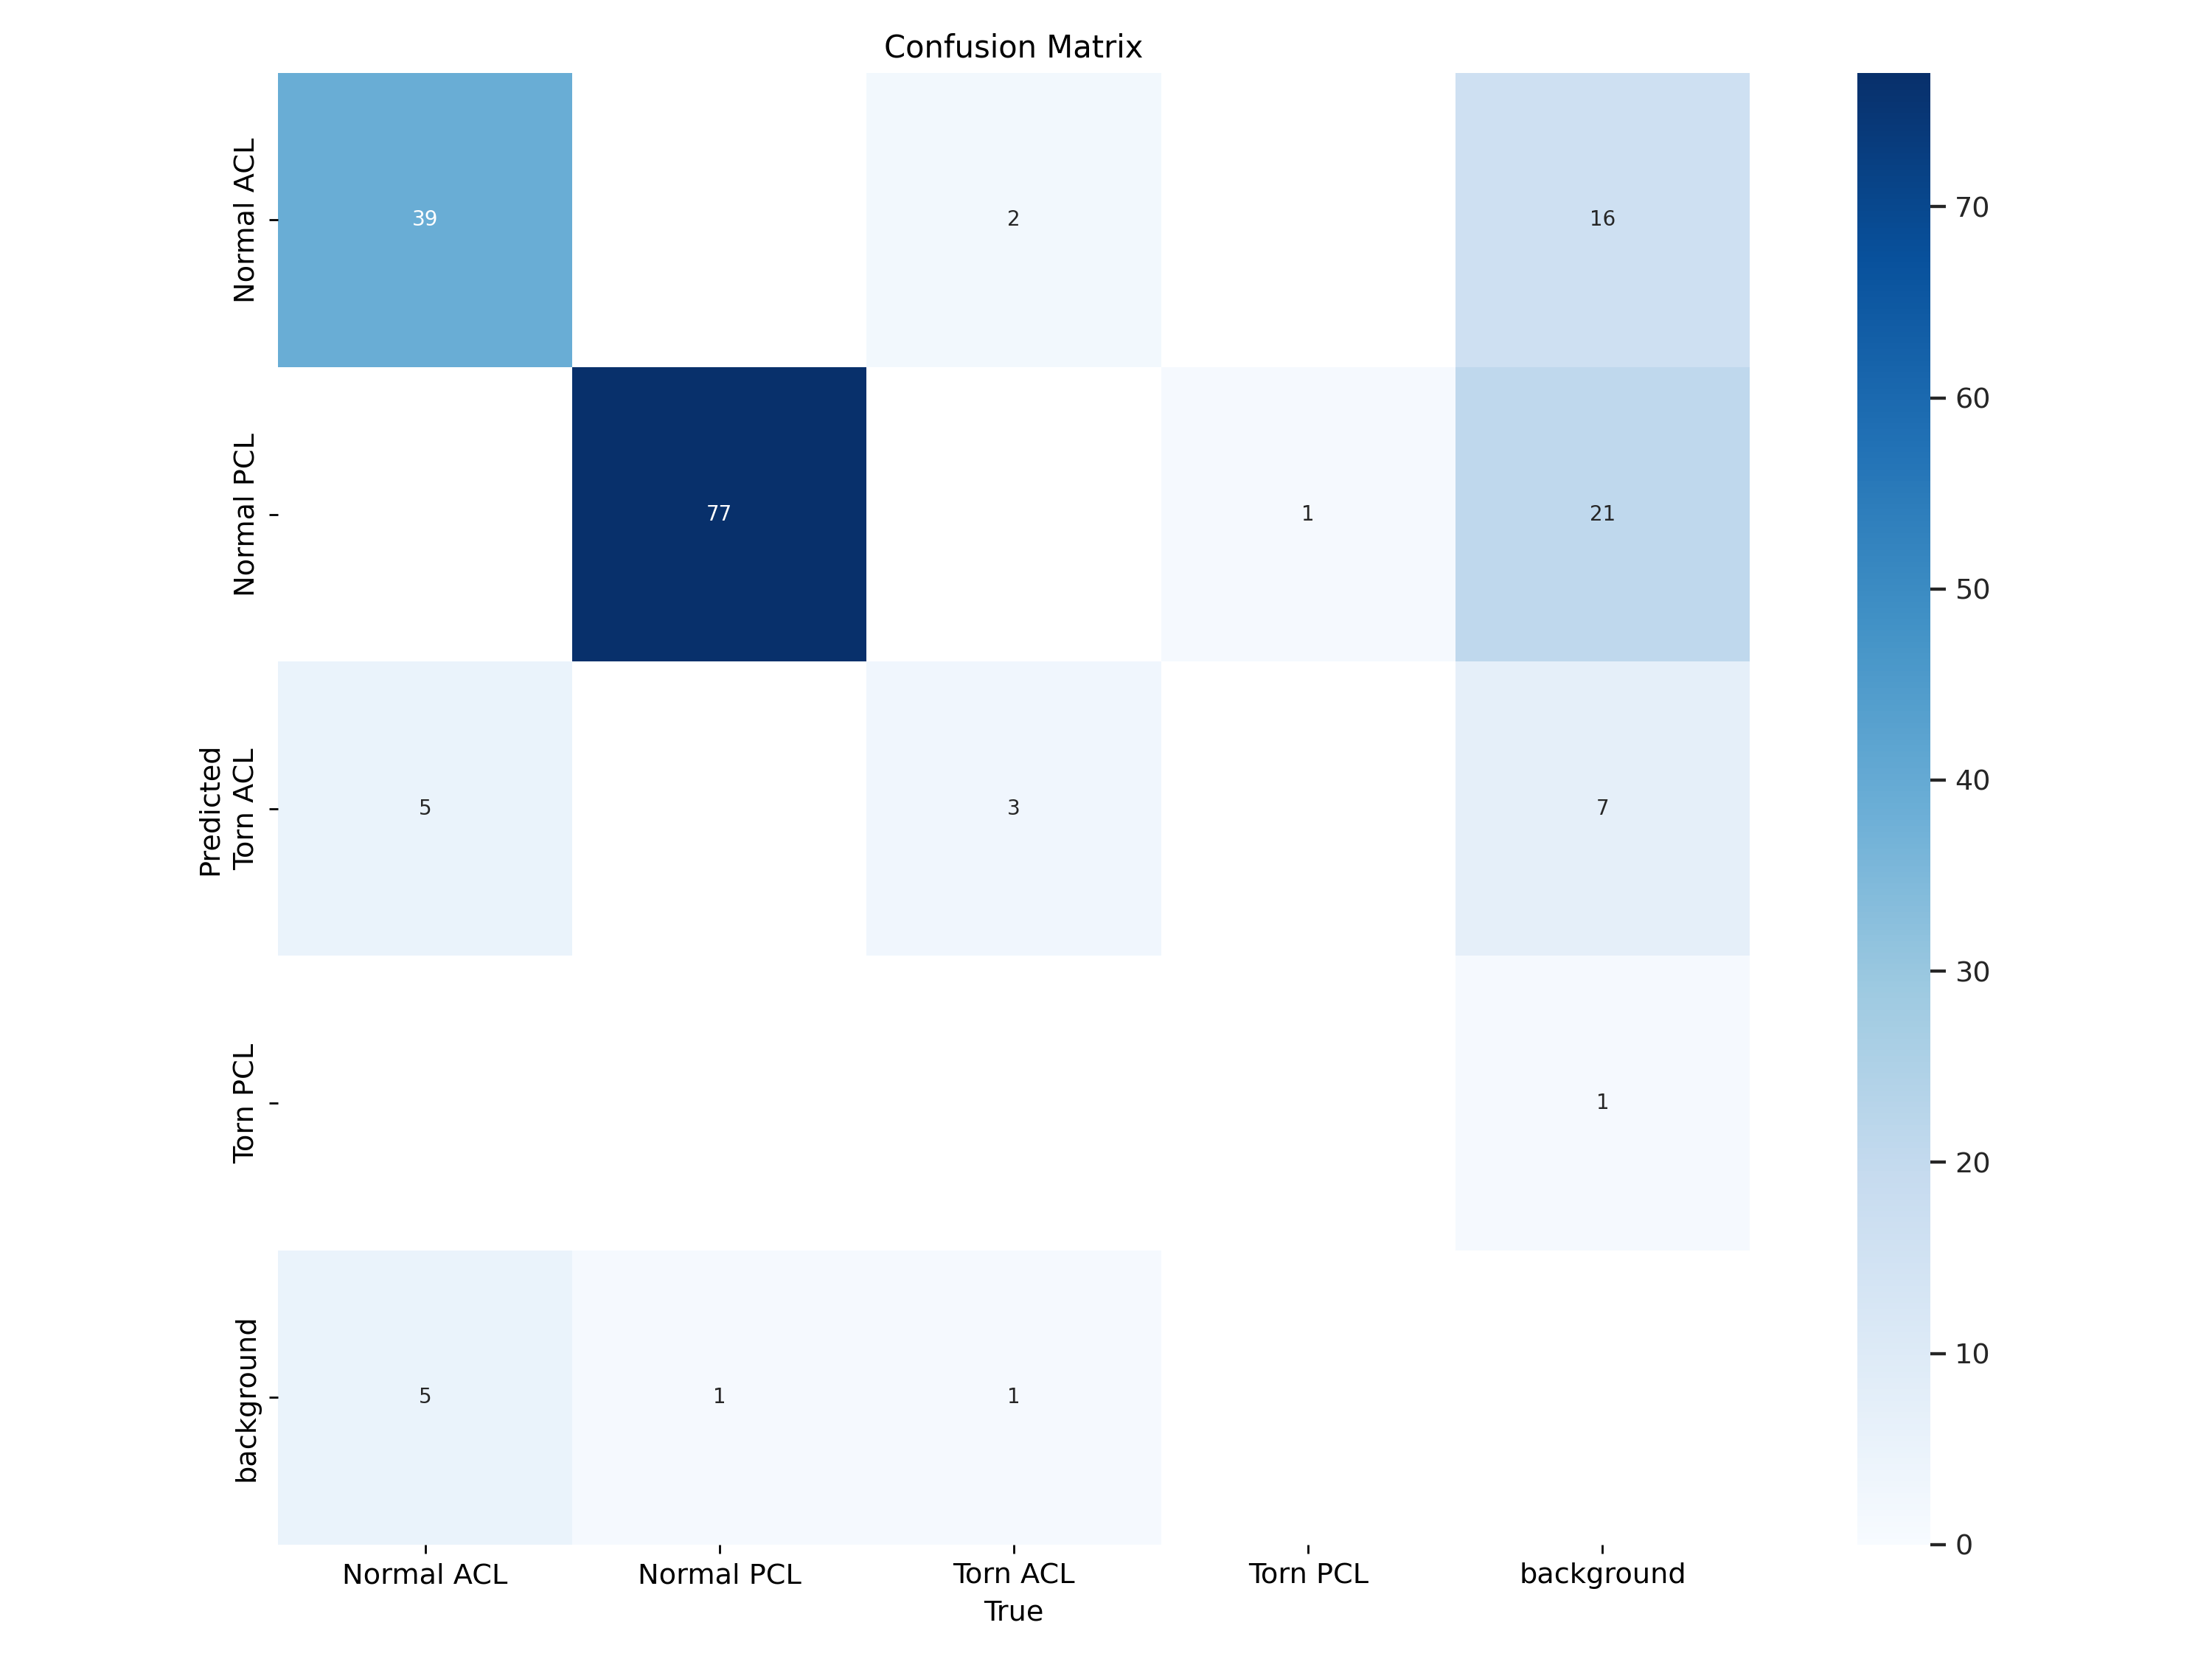

In [5]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'/kaggle/working/runs/detect/train/confusion_matrix.png', width=600)

In [6]:
!yolo task=detect mode=predict model=/kaggle/working/runs/detect/train/weights/best.pt conf=0.25 source=/kaggle/working/ACL-and-PCL-Detection-1/test/images save=True

Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs

image 1/194 /kaggle/working/ACL-and-PCL-Detection-1/test/images/ax_pd_fs_102_jpg.rf.460b464676ef48de197433be79d483bc.jpg: 640x640 1 Normal ACL, 1 Normal PCL, 9.7ms
image 2/194 /kaggle/working/ACL-and-PCL-Detection-1/test/images/ax_pd_fs_104_jpg.rf.95b0a5aa1bb6c4f8ca8c90704606ad92.jpg: 640x640 1 Normal PCL, 8.5ms
image 3/194 /kaggle/working/ACL-and-PCL-Detection-1/test/images/ax_pd_fs_107_jpg.rf.bc4d6c53a699704114cab19321ce0dc8.jpg: 640x640 1 Normal PCL, 8.4ms
image 4/194 /kaggle/working/ACL-and-PCL-Detection-1/test/images/ax_pd_fs_108_jpg.rf.fe6cec9c4c570b8bd111b1f4cd7c27e9.jpg: 640x640 2 Normal PCLs, 8.4ms
image 5/194 /kaggle/working/ACL-and-PCL-Detection-1/test/images/ax_pd_fs_114_jpg.rf.c9bcef6b0d4385c9235932737859f404.jpg: 640x640 1 Normal ACL, 1 Normal PCL, 8.4ms
image 6/194 /kaggle/working/ACL-and-PCL-Dete

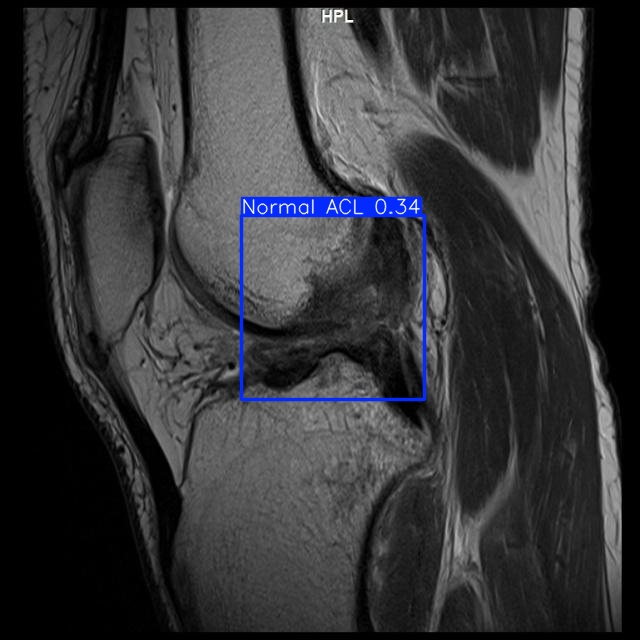

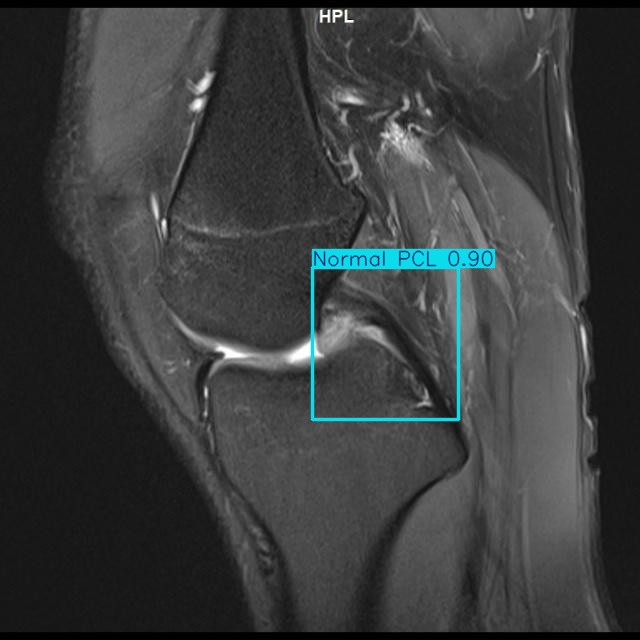

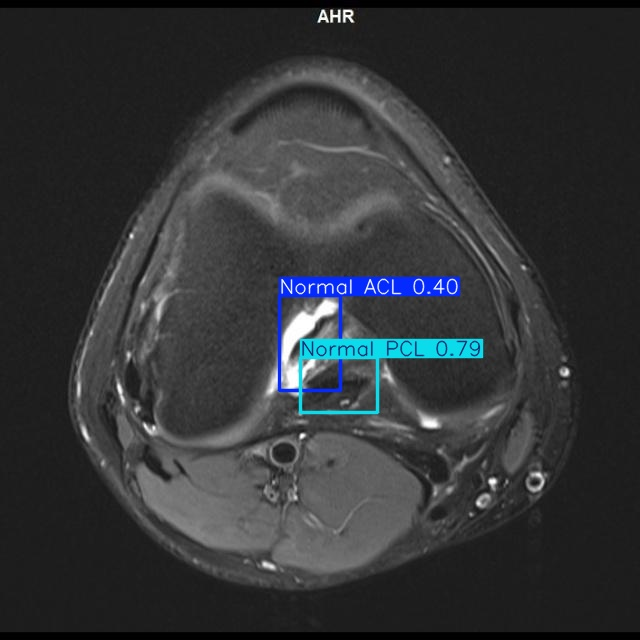

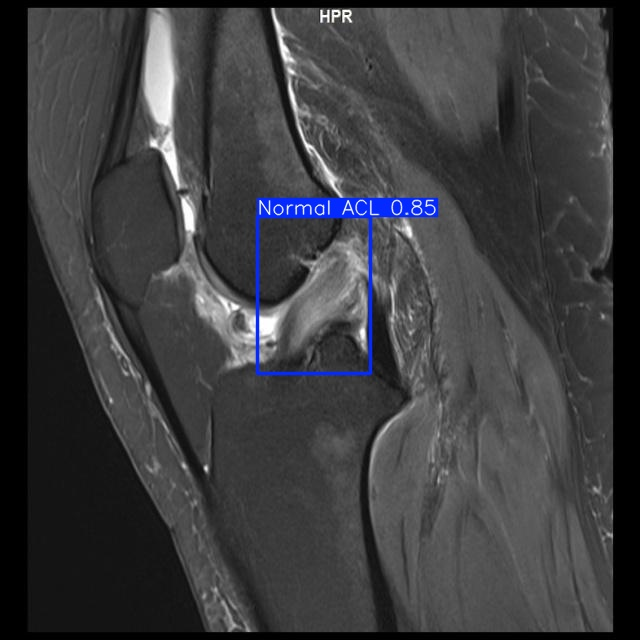

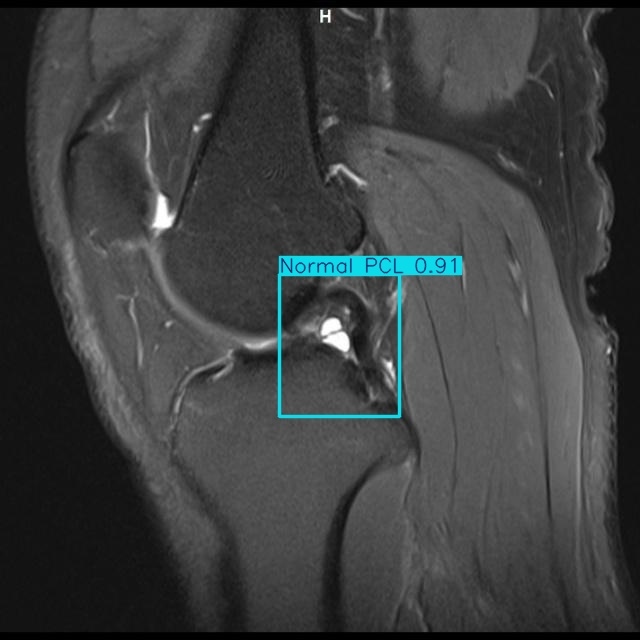

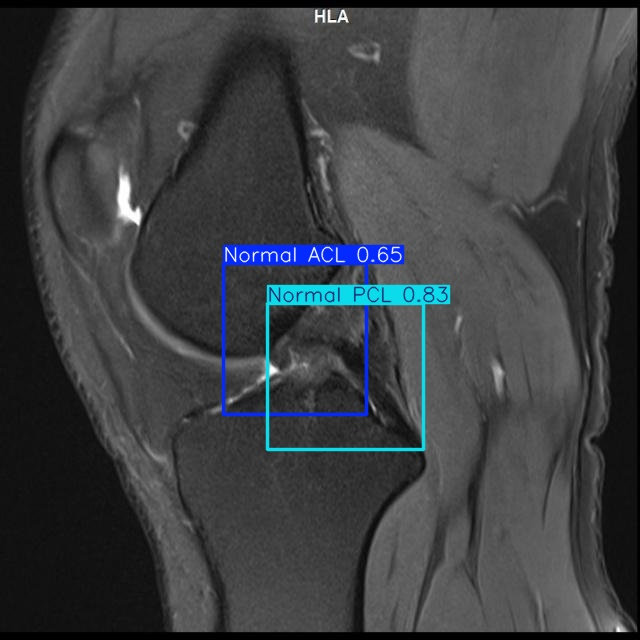

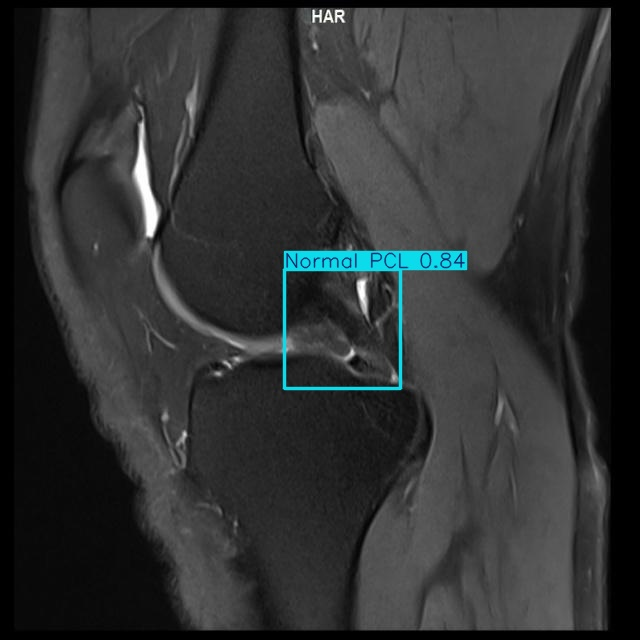

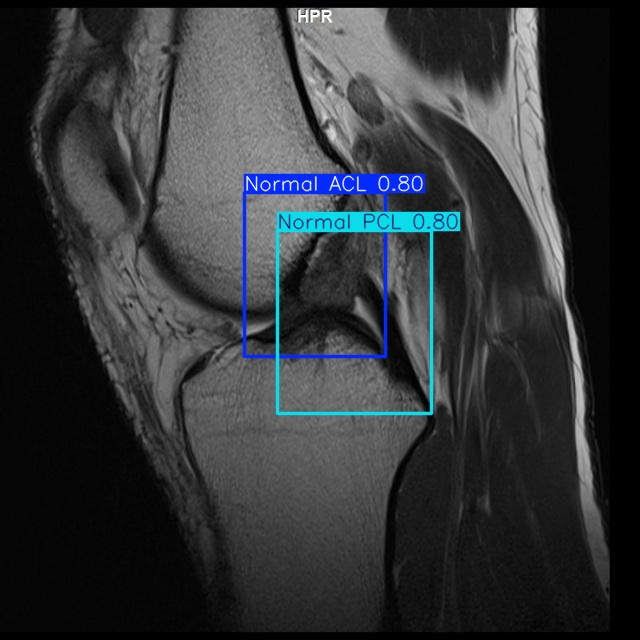

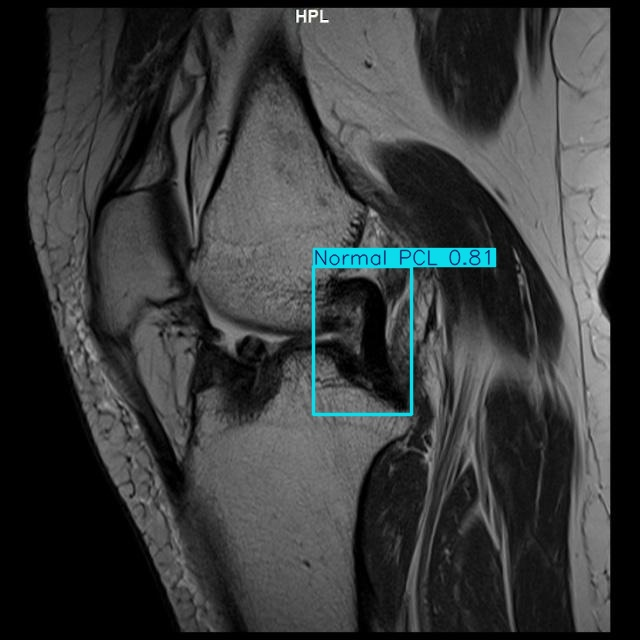

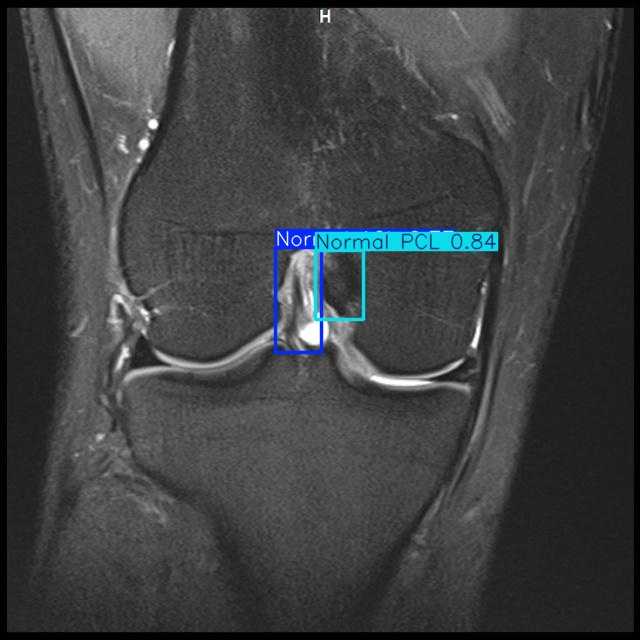

In [7]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/kaggle/working/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:10]:
	display(IPyImage(filename=img, width=600))
	print("\n")

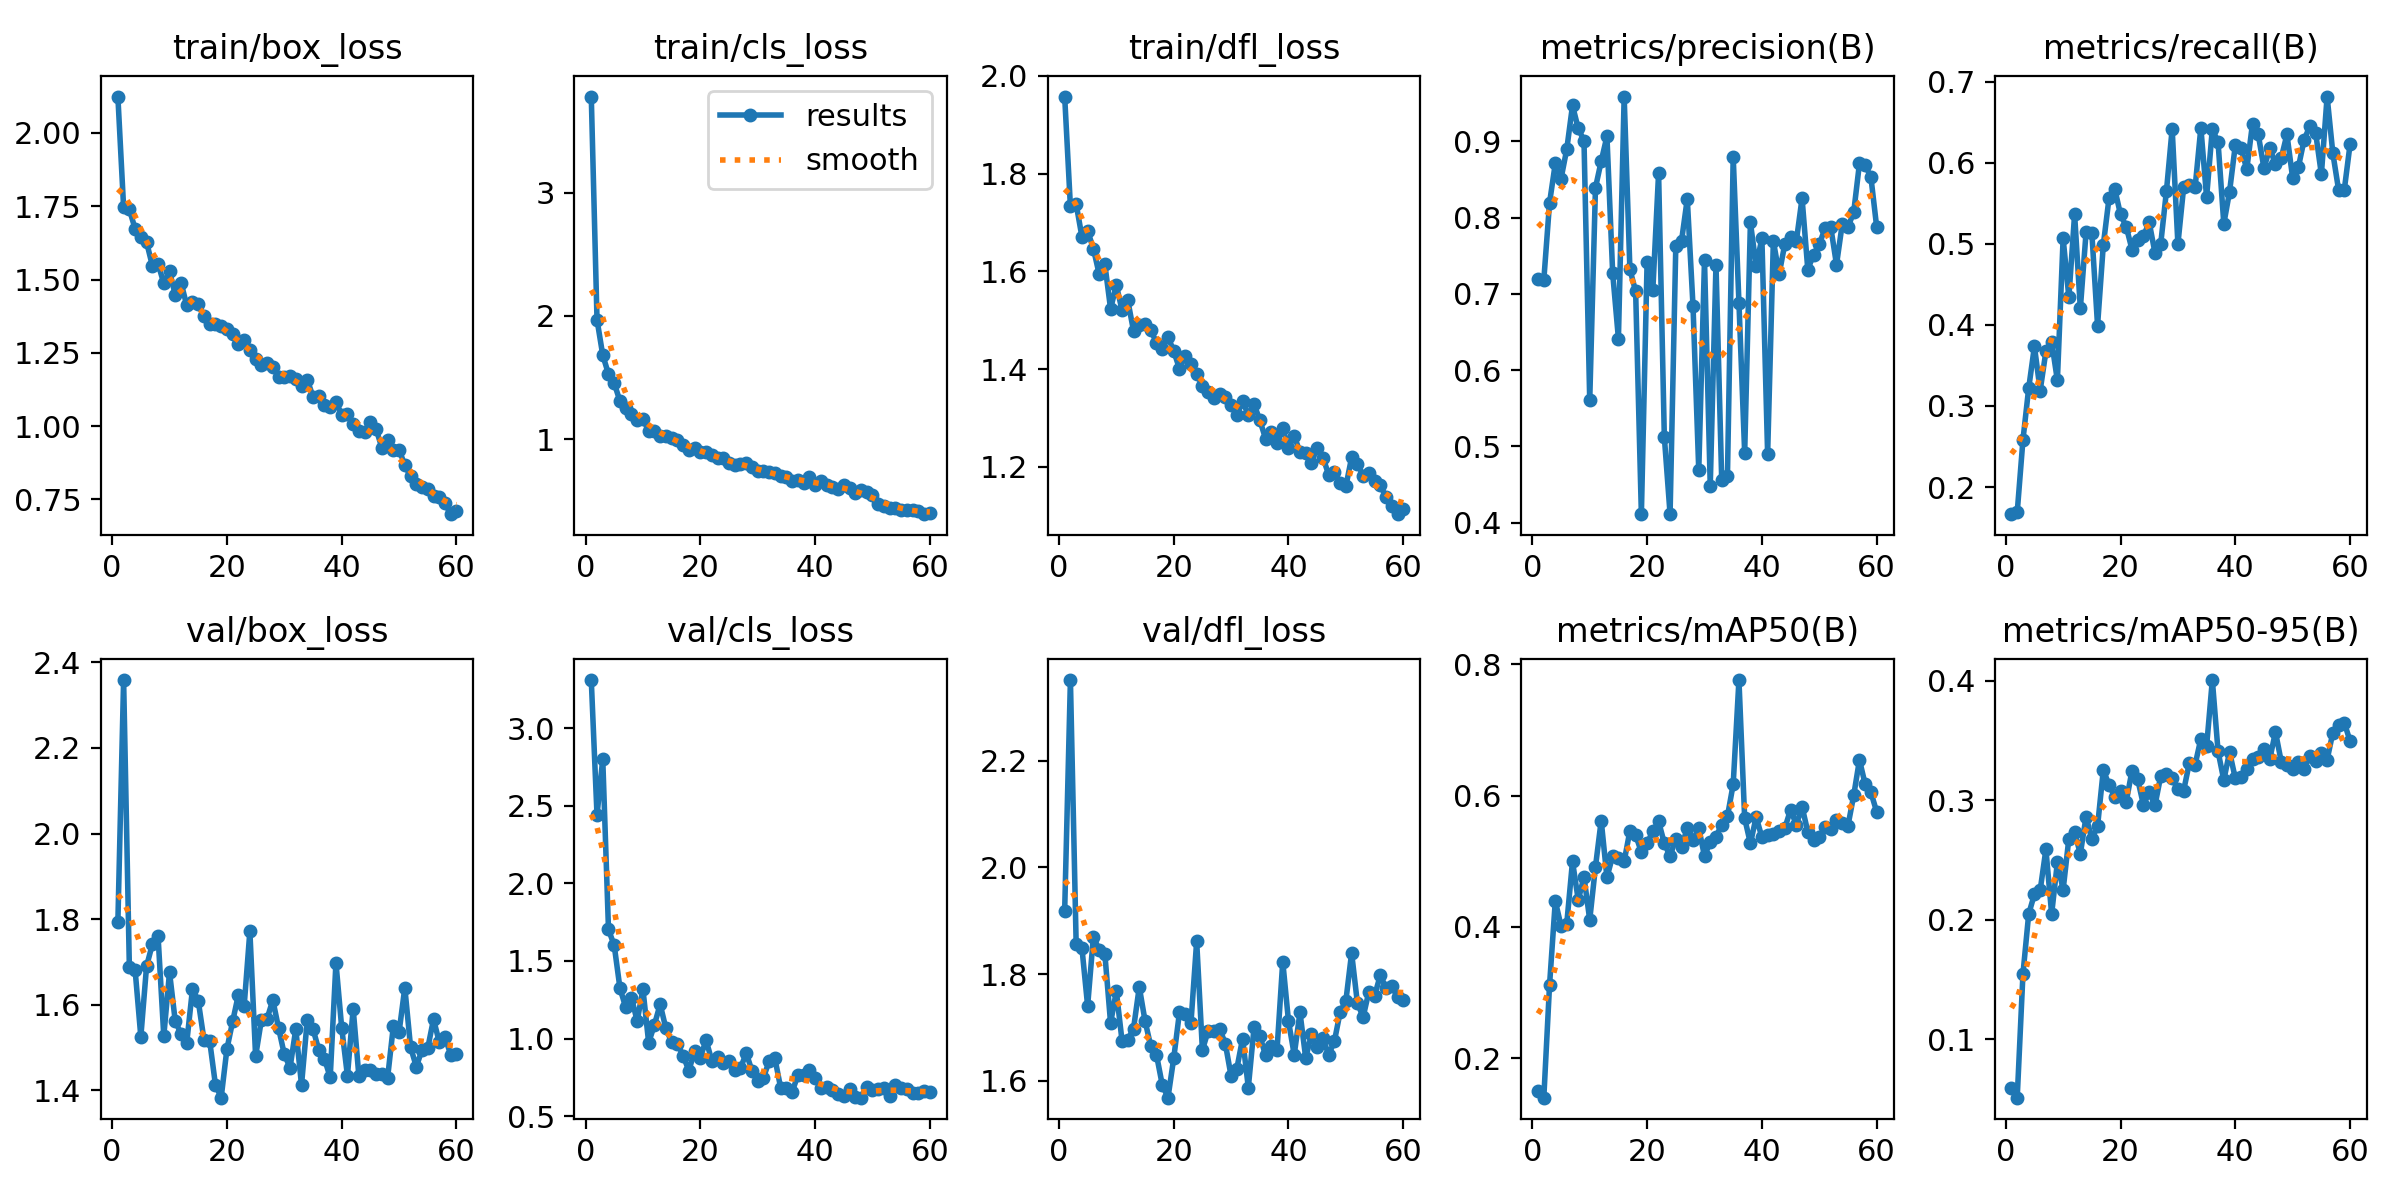

In [8]:
from IPython.display import Image as IPyImage

# Display training loss curves (accuracy, loss, and other metrics during training)
loss_curve_path = '/kaggle/working/runs/detect/train/results.png'
IPyImage(filename=loss_curve_path, width=600)


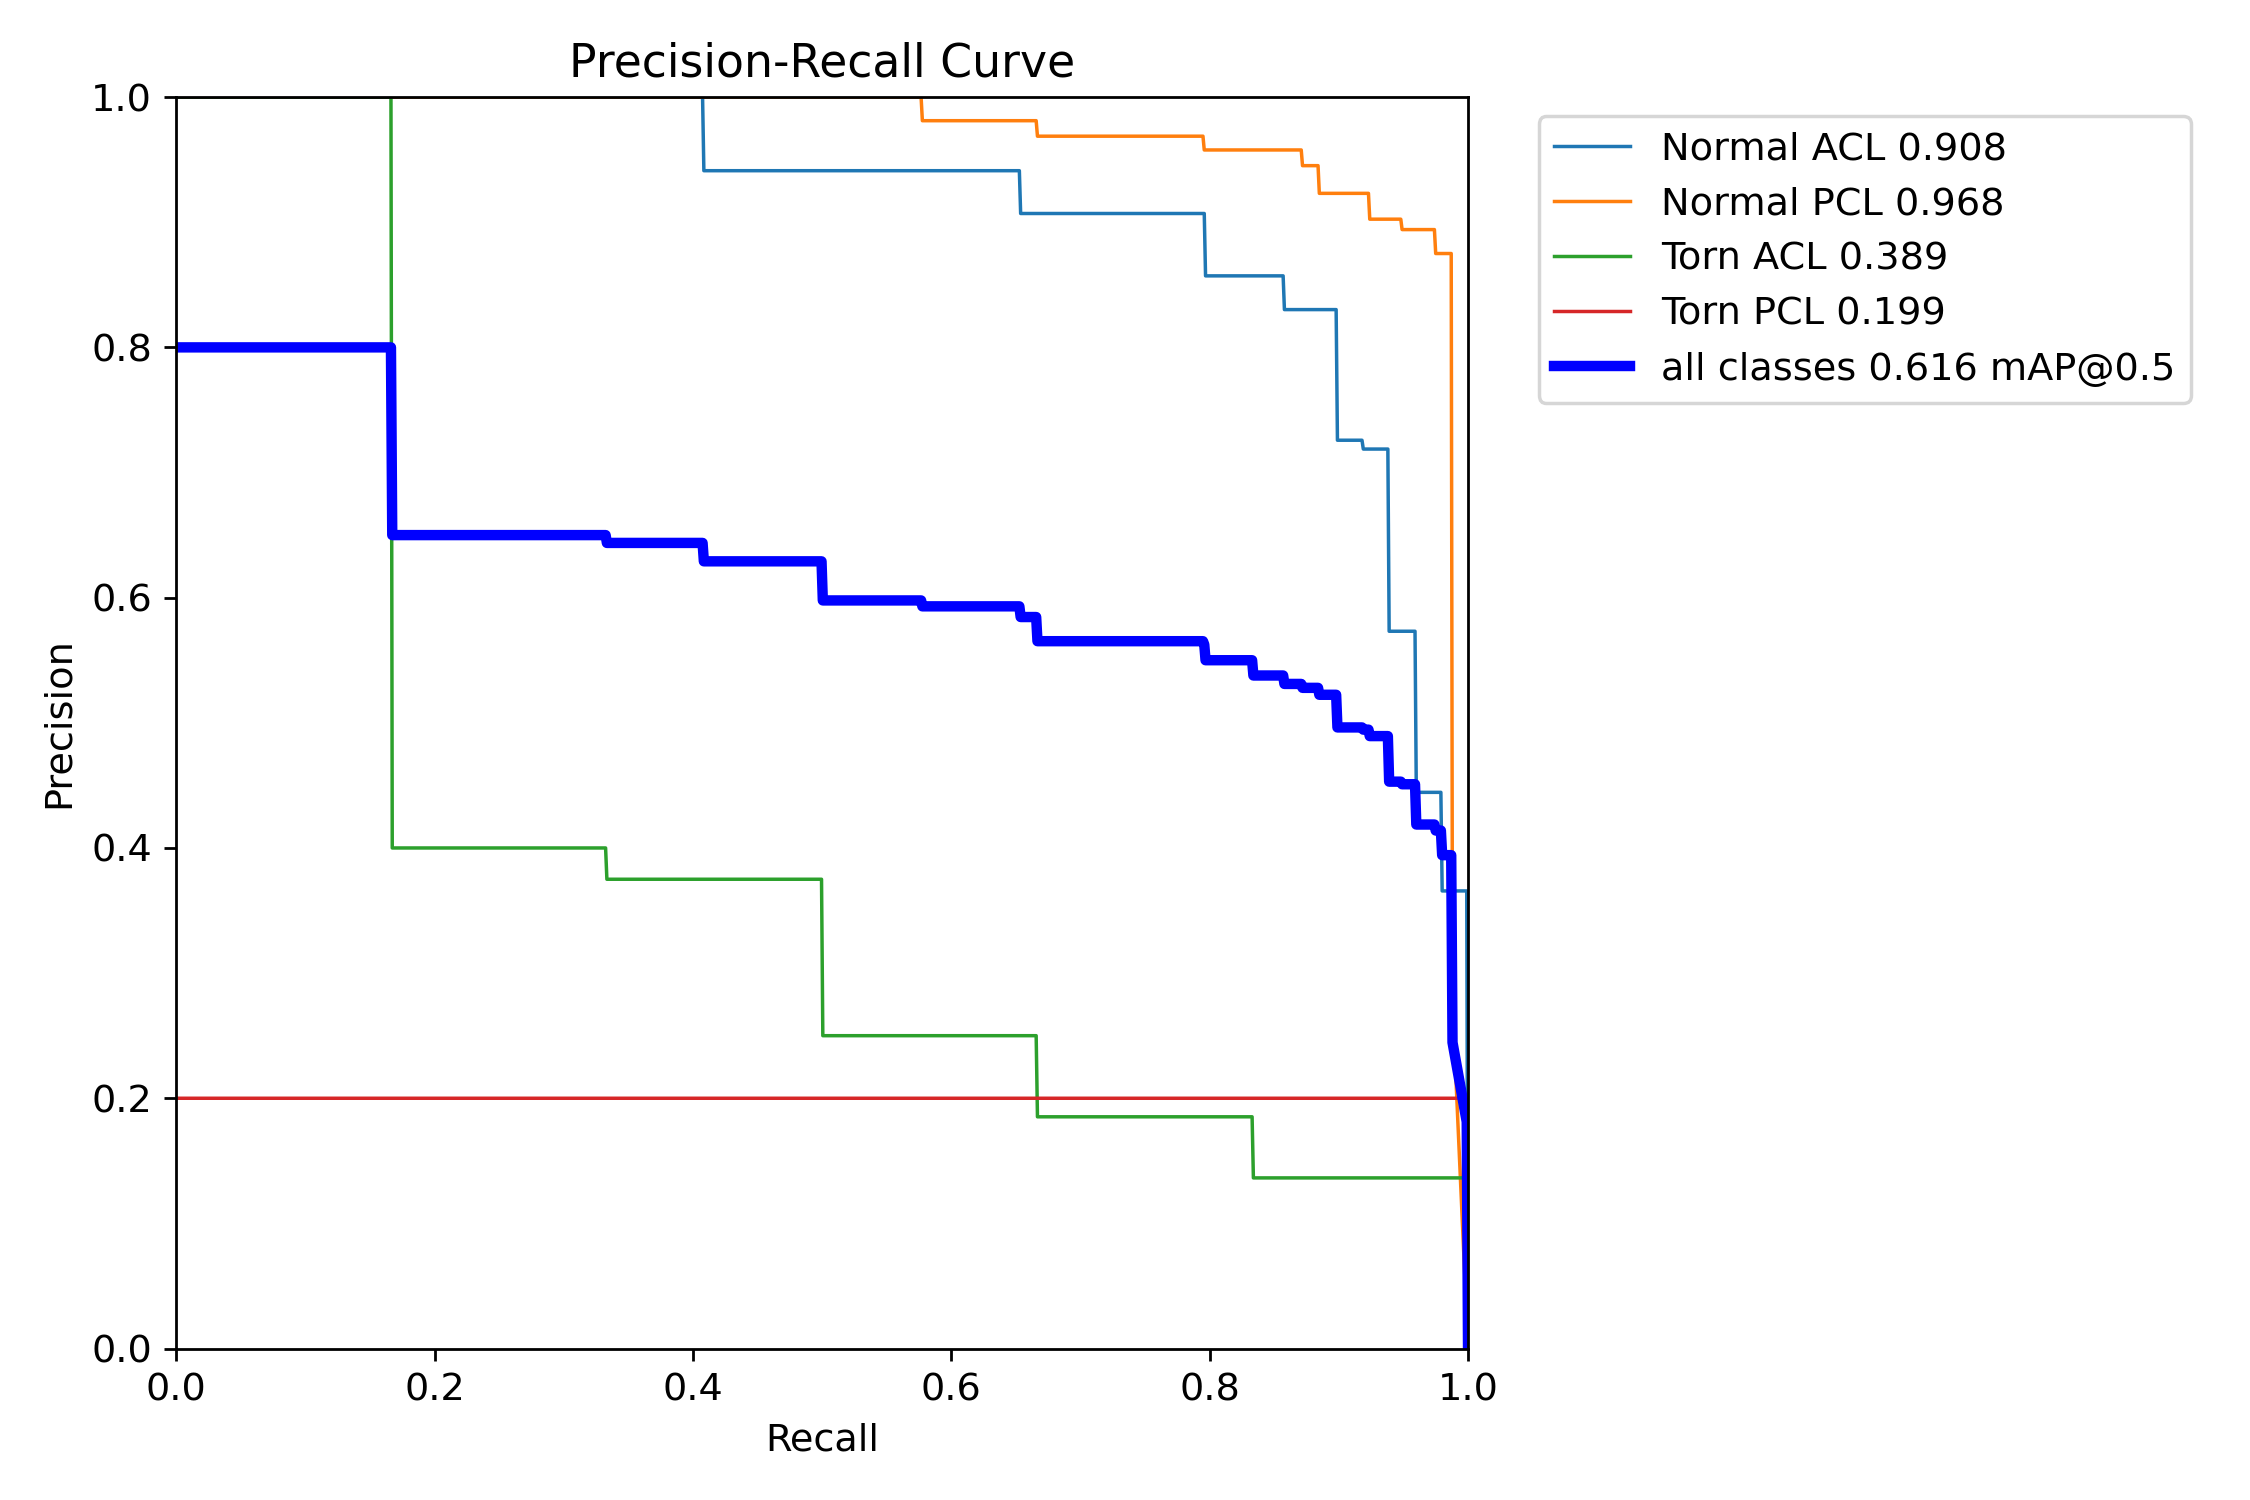

In [9]:
try:
    pr_curve_path = os.path.join("/kaggle/working/runs/detect/train/PR_curve.png")
    display(IPyImage(filename=pr_curve_path, width=800))
except FileNotFoundError:
    print(f"Precision-Recall curve image not found at: {pr_curve_path}")




0: 640x640 1 Normal ACL, 1 Normal PCL, 9.6ms
Speed: 1.4ms preprocess, 9.6ms inference, 172.3ms postprocess per image at shape (1, 3, 640, 640)
Objects detected, generating EigenCAM...


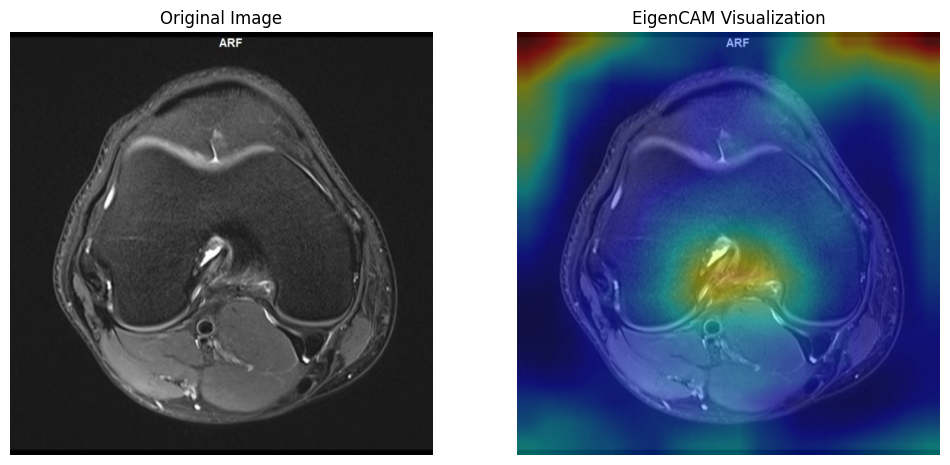

In [11]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from torchvision.transforms import Normalize

# Load trained YOLOv9 model
model_path = "/kaggle/working/runs/detect/train/weights/best.pt"  
model = YOLO(model_path)

# Select a test image
image_path = "/kaggle/working/ACL-and-PCL-Detection-1/test/images/ax_pd_fs_243_jpg.rf.5d9282b98e37cd74c91f4a02260a44a8.jpg"  
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Transform image for YOLOv8 inference
image_tensor = torch.tensor(image / 255.0, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

# Hook to extract activations from the last convolutional layer
def hook_fn(module, input, output):
    global activations
    activations = output.detach()

target_layer = model.model.model[9]
target_layer.register_forward_hook(hook_fn)

# Run inference
results = model(image_tensor)
boxes = results[0].boxes  # Bounding boxes

if boxes is None or len(boxes) == 0:
    print("No objects detected!")
else:
    print("Objects detected, generating EigenCAM...")
    
    # Compute eigen decomposition on feature activations
    activation_map = activations.squeeze().cpu().numpy()
    u, s, vh = np.linalg.svd(activation_map.reshape(activation_map.shape[0], -1), full_matrices=False)
    eigen_cam = np.abs(vh[0]).reshape(activation_map.shape[1:])
    eigen_cam = (eigen_cam - eigen_cam.min()) / (eigen_cam.max() - eigen_cam.min())  # Normalize
    eigen_cam = cv2.resize(eigen_cam, (image.shape[1], image.shape[0]))
    
    # Overlay heatmap on original image
    heatmap = cv2.applyColorMap(np.uint8(255 * eigen_cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)
    
    # Display both original image and EigenCAM side by side
    plt.figure(figsize=(12, 6))
    
    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title("Original Image")
    
    # EigenCAM Overlay
    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("EigenCAM Visualization")
    
    plt.show()
